# Dataset

The "Multi-class" dataset for the following code can be downloaded here:
https://sites.google.com/a/uah.edu/tommy-morris-uah/ics-data-sets [2]

Convert the individual .arff files to .csv before running this code. Put all .csv files in a single folder and change relevant filepaths within the code that follows. 

Imports and Setup
==================

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import os
import glob
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

from sklearn.model_selection import train_test_split 

from torch.nn import LSTM as lstm

import torch.optim as optim
from torch.optim import lr_scheduler
import time
from tempfile import TemporaryDirectory

from imblearn.over_sampling import BorderlineSMOTE

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Dataset Class
=============


In [3]:
class banpnvs_dataset(Dataset):
    """ binaryAllNaturalPlusNormalVsAttacks_CSV dataset (banpnvs), converted from .arff to .csv. """

    def __init__(self, root_dir, transform=None):
        """
        Arguments:
            root_dir (string): Directory with all the CSV data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        result = glob.glob(root_dir+'*.{}'.format('csv'))
        dfs = []
        for f in result: 
            df = pd.read_csv(f)
            df['group'] = df['marker'].ne(df['marker'].shift()).cumsum()
            df = df.groupby('group')
            for name, data in df:
                dfs.append(data)
            
        self.banpnvs_frame = dfs
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.banpnvs_frame)

    def __getitem__(self, idx):
        """ Each data sample is a time-series waveform """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.banpnvs_frame[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

# Data Preprocessing and Transforms


## Missing Data Values
There are instances in the dataset where data has either not been recorded, or captured in a faulty way. When these instances happen, errors in data capture must be handled. The four ways considered are replacing the missing or NaN value the median, mean, or zero, or to drop the sample entirely. Since [1] found that replacing the missing or NaN value with zero provided the best accuracy, that method was chosen. However, the difference between the best and worst methods of replacement only affected the results by at most 0.52%. 


## Class Imbalance
While the number of realizations of each type of event scenarios produces an almost uniformly-distributed histogram, the individual realizations themselves are not the same length. For example, the both event scenarios 41 ("No event") and 40 ("L1 maintenance with R1 and R2 disabled") occurs 15 times in the data, but the sum of all individual datum in class 41 more than doubles those found in class 40. For this reason, oversampling is performed to even the number of data points per class overall. The Borderline SMOTE algorithm is chosen for reasons listed in [1], but some initialization parameters, such as the number of nearest neighbors, need to be assumed. 


## Data Scaling
Input features should be scaled to the same magnitude with zero mean and unit variance as to not bias the model's result towards one input feature based on its raw value alone. The standard scaler was found by [1] to produce the best results, and thus this method was chosen. The standard scaler is written as: 
$$
\begin{aligned}
  \frac{x_i - \bar{x}}{\sigma}
\end{aligned}
$$



In [31]:
class ReplaceWithZero(object):
    """ Replace NaN values with zero and insert zeroes where data is missing. """
    def __call__(self, sample):  
        # sample is a dataframe
        return sample.fillna(0) #np.nan_to_num(sample)

    
class BalanceClasses(object):
    """ 
    Add more instances of classes (indicated by field 'marker') so that all classes have the same number of realizations. 
    Resample via Borderline Smote algorithm. 
    """
    def __call__(self, sample):
        resampled = BorderlineSMOTE().fit_resample(sample)
        return resampled

    
class StandardScaler(object):
    """ Scale input features to the same magnitude with zero mean and unit variance. """
    def __call__(self, sample):
        normalized_sample = (sample - np.mean(sample)) / np.std(sample)
        return normalized_sample

    
class FeatureSelection(object):
    """ Select which features to use as input into model. """

    def __call__(self, sample):
        return sample.drop(columns=['control_panel_log1','control_panel_log2','control_panel_log3','control_panel_log4','relay1_log','relay2_log','relay3_log','relay4_log','snort_log1','snort_log2','snort_log3','snort_log4'])

In [32]:
banpnvs_data = banpnvs_dataset(root_dir='data/binaryAllNaturalPlusNormalVsAttacks_CSV/')
composed = transforms.Compose([FeatureSelection(), ReplaceWithZero(), BalanceClasses(), StandardScaler()])

### Single data example and is transform

In [33]:
sample = banpnvs_data[0]
print(type(sample))
print(sample.shape)
sample = composed(banpnvs_data[0])
print(type(sample))
print(sample.shape)

<class 'pandas.core.frame.DataFrame'>
(173, 131)
<class 'pandas.core.frame.DataFrame'>
(173, 119)


### Simple for-loop-based iteration over dataset

In [34]:
transformed_dataset = banpnvs_dataset(root_dir='data/binaryAllNaturalPlusNormalVsAttacks_CSV/',
                                           transform=transforms.Compose([
                                               FeatureSelection(),
                                               ReplaceWithZero(),
                                               BalanceClasses(),
                                               StandardScaler()
                                           ]))

for i, sample in enumerate(transformed_dataset):
    #print(sample['marker'][0])
    print(i, type(sample), sample.size, sample['marker'].iloc[0])

    if i == 3:
        break

0 <class 'pandas.core.frame.DataFrame'> 20587 41
1 <class 'pandas.core.frame.DataFrame'> 16184 40
2 <class 'pandas.core.frame.DataFrame'> 16184 39
3 <class 'pandas.core.frame.DataFrame'> 33915 38


In [228]:
transformed_dataset

## Transforms for Training, Validation, and Test Sets

In [37]:
data_transforms = {
    'train': transforms.Compose([
        FeatureSelection(),
        ReplaceWithZero(),
        BalanceClasses(),
        StandardScaler()
    ]),
    'val': transforms.Compose([
        FeatureSelection(),
        ReplaceWithZero(),
        BalanceClasses(),
        StandardScaler()
    ]),
    'test': transforms.Compose([
        FeatureSelection(),
        ReplaceWithZero(),
        BalanceClasses(), # Potentially exclude this from test set
        StandardScaler() # Potentially exclude this from test set
    ]),
}

In [ ]:
data_dir = 'data/binaryAllNaturalPlusNormalVsAttacks_CSV/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [ ]:
## Create Training, Testing, and Valudation Sets

In [ ]:
path = 'data/binaryAllNaturalPlusNormalVsAttacks_CSV/'
extension = 'csv'
result = glob.glob(path+'*.{}'.format(extension))
train_result = result[:12]
dfs_xtrain = []
dfs_ytrain = []
sid = 0
for x in train_result: 
    df = pd.read_csv(x)
    dfs_xtrain.append(df)

dfs_xtrain = pd.concat(dfs_xtrain)



dfs_xtrain['series_id'] = ""
inc = 0
val = 0
cii = dfs_xtrain['marker'].iloc[0]
for ii in dfs_xtrain['marker']:
    if ii != cii:
        cii = ii
        print("1. Resetting at inc " + str(inc) + " and val " + str(val))
        val = val + 1        
    dfs_xtrain.at[inc,'series_id'] = val
    inc = inc + 1


dfs_xtrain['measurement_number'] = ""
inc = 0
val = 0
cii = dfs_xtrain['marker'].iloc[0]
for ii in dfs_xtrain['marker']:
    #print(ii)
    if ii != cii:
        cii = ii
        print("2. Resetting at inc " + str(inc) + " and val " + str(val))
        val = 0
    else:
        val = val + 1
    dfs_xtrain.at[inc, 'measurement_number'] = val
    inc = inc + 1


## LSTM Model

In [ ]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
        return (h0, c0)

### Visualize Mode Structure

In [ ]:
import hiddenlayer as hl

transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.


input_dim = 117    
hidden_dim = 256
layer_dim = 3
output_dim = 9
seq_dim = 128

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)


graph = hl.build_graph(model, args=torch.zeros(1, 1, input_dim), transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('lstm_hiddenlayer', format='png')

In [ ]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn['marker'])

### Training the model

In [12]:
input_dim = 10    
hidden_dim = 256
layer_dim = 3
output_dim = 9
seq_dim = 128

lr = 0.0005
n_epochs = 1000
iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model.cuda()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))


print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        sched.step()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in val_dl:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_lstm.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

### Train and evaluate

In [28]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


NameError: name 'dataloaders' is not defined

In [124]:
# # Reproduce Fig. 2 from [1]

# s = set()
# for x in dfs:
#     mkr = x['marker'].iloc[0] 
#     s.add(mkr)

# #print(s)


# cd = np.zeros(shape=(len(s),2), dtype=int)
# cd[:, 0] = np.array(list(s))
# #print(cd)

# # This is not efficient... but it only ever runs once!
# for x in dfs:
#     mkr = x['marker'].iloc[0] 
#     idx = np.nonzero(cd[:, 0] == mkr)
#     cd[idx, 1] = cd[idx, 1]+1;

# #print(cd)




# bin_edges_low = cd[:, 0]-0.5
# bin_edges_high = cd[:, 0]+0.5
# bin_edges = np.concatenate((bin_edges_low, bin_edges_high))
# bin_edges = np.sort(bin_edges)


# fig, ax = plt.subplots()

# # the histogram of the data
# n, bins, patches = ax.hist(cd[:,1], bin_edges, density=True)


# ax.set_xlabel('Classes')
# ax.set_ylabel('Data Samples')
# ax.set_title('Class Distribution before Resampling')

# # Tweak spacing to prevent clipping of ylabel
# fig.tight_layout()
# plt.show()

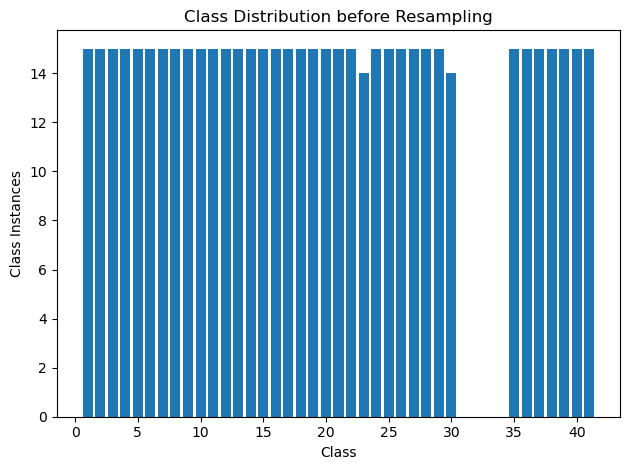

In [45]:
# Reproduce Fig. 2 from [1]
# Oddly enough, it was found that the classes were almost uniformly distributed. 
# Either the original paper's 80%/20% split of training/testing data was performed without taking class distribution into account, 
# or they use "samples" as individual data points. The latter seems most likely. 

s = set()
for x in dfs:
    mkr = x['marker'].iloc[0] 
    s.add(mkr)

cd = np.zeros(shape=(len(s),2), dtype=int)
cd[:, 0] = np.array(list(s))

# This is not efficient... but it only ever runs once!
for x in dfs:
    mkr = x['marker'].iloc[0] 
    idx = np.nonzero(cd[:, 0] == mkr)
    cd[idx, 1] = cd[idx, 1]+1;


fig, ax = plt.subplots()
ax.bar(cd[:,0], cd[:,1])
ax.set_xlabel('Class')
ax.set_ylabel('Class Instances')
ax.set_title('Class Distribution before Resampling')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

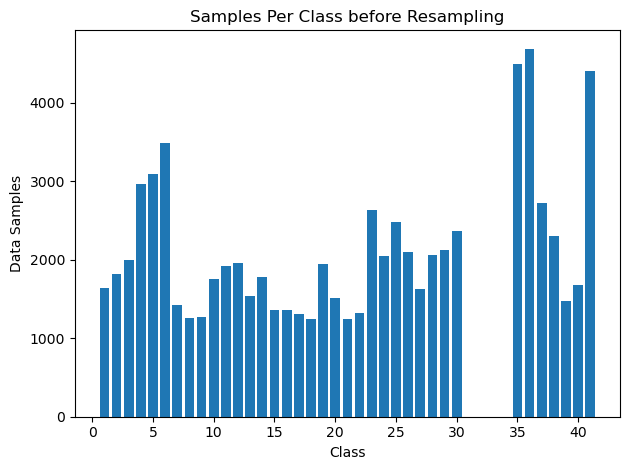

In [46]:
# Reproduce Fig. 2 from [1]
# This is now the correct reproduction of the original figure. 

s = set()
for x in dfs:
    mkr = x['marker'].iloc[0] 
    s.add(mkr)

cd = np.zeros(shape=(len(s),2), dtype=int)
cd[:, 0] = np.array(list(s))

# This is not efficient... but it only ever runs once!
for x in dfs:
    mkr = x['marker'].iloc[0] 
    idx = np.nonzero(cd[:, 0] == mkr)
    cd[idx, 1] = cd[idx, 1]+len(x);


fig, ax = plt.subplots()
ax.bar(cd[:,0], cd[:,1])
ax.set_xlabel('Class')
ax.set_ylabel('Data Samples')
ax.set_title('Samples Per Class before Resampling')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

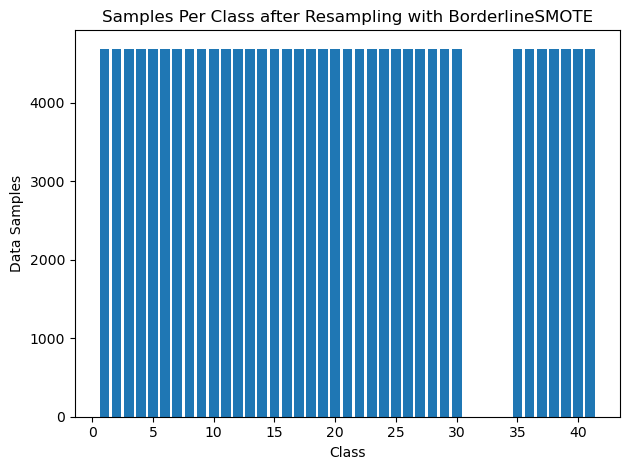

In [47]:
# Reproduce Fig. 2 from [1]
# This is now the correct reproduction of the original figure. 

s = set()
for x in dfs:
    mkr = x['marker'].iloc[0] 
    s.add(mkr)

cd = np.zeros(shape=(len(s),2), dtype=int)
cd[:, 0] = np.array(list(s))

# This is not efficient... but it only ever runs once!
for x in dfs:
    mkr = x['marker'].iloc[0] 
    idx = np.nonzero(cd[:, 0] == mkr)
    cd[idx, 1] = 4685;


fig, ax = plt.subplots()
ax.bar(cd[:,0], cd[:,1])
ax.set_xlabel('Class')
ax.set_ylabel('Data Samples')
ax.set_title('Samples Per Class after Resampling with BorderlineSMOTE')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

# References

[1] Y. A. Farrukh, Z. Ahmad, I. Khan and R. M. Elavarasan, "A Sequential Supervised Machine Learning Approach for Cyber Attack Detection in a Smart Grid System," 2021 North American Power Symposium (NAPS), College Station, TX, USA, 2021, pp. 1-6, doi: 10.1109/NAPS52732.2021.9654767.

[2] U. Adhikari, S. Pan, T. Moris, R. Borges, and J. Beaver , “Industrial Control System (ICS) Cyber Attack Datasets,” Tommy Morris. 2016. [Online]. Available: https://www.sites.google.com/a/uah.edu/tommymorris-uah/ics-data-sets

[3] Elmrabit, N, Zhou, F, Li, F & Zhou, H 2020, Evaluation of machine learning algorithms for anomaly detection. in2020 International Conference on Cyber Security and Protection of Digital Services (Cyber Security)., 9138871,IEEE, International Conference on Cyber Security and Protection of Digital Services, 15/06/20

[4] S. Pan, T. Morris and U. Adhikari, "Developing a Hybrid Intrusion Detection System Using Data Mining for Power Systems," in IEEE Transactions on Smart Grid, vol. 6, no. 6, pp. 3104-3113, Nov. 2015, doi: 10.1109/TSG.2015.2409775. 



### Code used as references
https://github.com/ritchieng/deep-learning-wizard/blob/master/docs/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork.ipynb

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://pytorch.org/vision/stable/models.html#classification

https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

https://www.kaggle.com/code/purplejester/a-simple-lstm-based-time-series-classifier/notebook